In [38]:
from langchain_openai import ChatOpenAI
from langchain.schema import Document
llm = ChatOpenAI(model="gpt-4")

def Calculate_EI_benefit(hourly_rate: float, weekly_hours: float) -> float:
    """
    Calculate the estimated weekly EI benefit.

    :param hourly_rate: User's hourly wage
    :param weekly_hours: Number of hours worked per week
    :param family_income: Net family income (optional)
    :param has_children: Whether the user has children (optional)
    :return: Estimated weekly EI benefit
    """
    weekly_earnings = hourly_rate * weekly_hours
    benefit_rate = 0.55

    # Check for Family Supplement eligibility

    weekly_benefit = weekly_earnings * benefit_rate
    return min(weekly_benefit, 695.00)
    
tools = [Calculate_EI_benefit]
llm_with_tools = llm.bind_tools(tools)

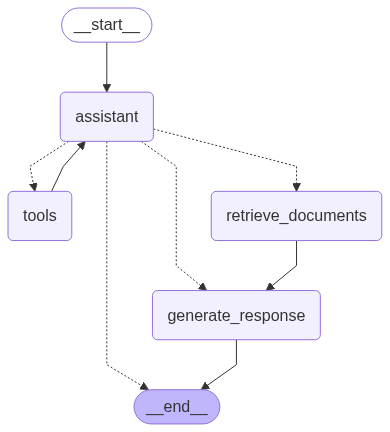

In [39]:
import operator
from langchain.chat_models import ChatOpenAI
from langgraph.graph import START, StateGraph
from langchain.chains import RetrievalQA
from langgraph.graph import MessagesState
from typing_extensions import List, Optional,TypedDict, Annotated, Literal
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, get_buffer_string
from langchain.embeddings import OpenAIEmbeddings
from langchain.tools import Tool
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Initialize components

embedding_model = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings(api_key=OPENAI_API))
retriever = vectorstore.as_retriever()

sys_msg = SystemMessage(content="You are a helpful EI assistant only if user ask for benefit rate or to calculate EI benefit use tool to calculate")
# Define the state schema
class GraphState(TypedDict):
    user_input: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# System message


# Node
def assistant(state: GraphState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Define the calculator tool

    
def should_invoke_tool(state) -> Literal["retrieve_documents", "generate_response"]:
    documents = state.get("documents", [])
    if documents:
        return "generate_response"
    else:
        return "retrieve_documents"
"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    user_input = state["user_input"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {user_input}")
    return {"documents": documents}


@traceable(run_type="chain")
def generate_response(state: GraphState):
    user_input = state["user_input"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = rag_chain.invoke({"input": user_input, "chat_history": messages , "context": formatted_docs}).text
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [generation]}

# Build the LangGraph
builder = StateGraph(GraphState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("retrieve_documents", retrieve_documents)
builder.add_node("generate_response", generate_response)
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
#builder.add_edge("tools", END)
builder.add_conditional_edges("assistant", should_invoke_tool)
builder.add_edge("tools", "assistant")
builder.add_edge("retrieve_documents", "generate_response")
builder.add_edge("generate_response", END)

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))



In [43]:
import uuid
if __name__ == "__main__":
    thread_id = str(uuid.uuid4())  # Unique ID for the session
    config = {"configurable": {"thread_id": thread_id}}
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Assistant: Goodbye!")
            break
        response = react_graph.invoke({"messages": [HumanMessage(content=user_input)], "user_input" : user_input}, config=config)
        messages = response.get("messages", [])
        if response:
            for m in response['messages']:
                m.pretty_print()
            
        else:
            print("Assistant: I'm sorry, I didn't catch that.")


You:  Calculate my EI benefit with an hourly rate of 30, working 40 hours per week


================================ Human Message =================================

Calculate my EI benefit with an hourly rate of 30, working 40 hours per week
================================== Ai Message ==================================
Tool Calls:
  Calculate_EI_benefit (call_B8lWLjAxCJQ3Qhw7QDTbsR8W)
 Call ID: call_B8lWLjAxCJQ3Qhw7QDTbsR8W
  Args:
    hourly_rate: 30
    weekly_hours: 40
================================= Tool Message =================================
Name: Calculate_EI_benefit

660.0
================================== Ai Message ==================================

Based on your input, your estimated weekly Employment Insurance (EI) benefit would be $660.00. Please note that this is an estimated figure and the actual amount may vary.
================================== Ai Message ==================================

Based on the hourly rate of $30 and working 40 hours per week that you provided, the calculation for your Employment Insurance (EI) benefit comes out to 

You:  I need to travel abroad what will happen to my EI?


================================ Human Message =================================

I need to travel abroad what will happen to my EI?
================================== Ai Message ==================================

As an EI assistant, I'm here to assist you with benefit rates and calculations. However, in general, it's important to know that traveling abroad may affect your eligibility to receive Employment Insurance benefits. Recipients are usually required to stay in Canada and be available for work. There are exceptions, but you would need to verify with the relevant authorities. Please check with the Canada Service for specific guidelines.
================================== Ai Message ==================================

Traveling abroad can impact your eligibility for Employment Insurance (EI) benefits. Recipients are typically expected to remain within Canada and be ready for work. Certain exceptions do exist, but you should check with Canada Service for specific guidance. It's cr

You:  exit


Assistant: Goodbye!
